In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from src.models.GRU import GRUVAE
from src.dataloader import EventMidiDataset
from src.dataloader.midi_parser import piano_roll_to_pretty_midi
import os
from tqdm import tqdm
from matplotlib import cm, colors as mcolors, pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from sklearn.decomposition import PCA

In [49]:
model = GRUVAE()
model.load_state_dict(torch.load('best_model.pt'))
model.cuda()

GRUVAE(
  (pitch_embedding): Embedding(84, 128)
  (velocity_proj): Linear(in_features=1, out_features=128, bias=True)
  (time_proj): Linear(in_features=1, out_features=128, bias=True)
  (duration_proj): Linear(in_features=1, out_features=128, bias=True)
  (encoder_gru): GRU(128, 256, batch_first=True)
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (latent_to_hidden): Linear(in_features=64, out_features=256, bias=True)
  (decoder_gru): GRU(192, 256, batch_first=True)
  (out_pitch): Linear(in_features=256, out_features=84, bias=True)
  (out_velocity): Linear(in_features=256, out_features=1, bias=True)
  (out_time): Linear(in_features=256, out_features=1, bias=True)
  (out_duration): Linear(in_features=256, out_features=1, bias=True)
)

In [3]:
def vae_kl_loss(mu, logvar):
    """
    Compute the KL divergence between the learned Gaussian distribution and a standard normal distribution.

    Args:
        mu (Tensor): Mean of the latent distribution. Shape [batch_size, latent_dim]
        logvar (Tensor): Log variance of the latent distribution. Shape [batch_size, latent_dim]

    Returns:
        Tensor: Scalar loss (KL divergence)
    """
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)  # per sample
    return kl.mean()  # average over batch

In [4]:
def loss_fn(output, target, beta):
    pitch_loss = nn.CrossEntropyLoss()(
        output['pitch'].reshape(-1, output['pitch'].shape[-1]),
        target[:, :, 0].reshape(-1).long()  # <-- cast to long
    )
    mse_loss = nn.MSELoss()
    
    velocity_loss = mse_loss(
        output['velocity'].reshape(-1, output['velocity'].shape[-1]),
        target[:, :, 1].reshape(-1, 1)
    )
    time_loss = mse_loss(
        output['time'].reshape(-1, output['time'].shape[-1]),
        target[:, :, 2].reshape(-1, 1)
    )
    duration_loss = mse_loss(
        output['duration'].reshape(-1, output['duration'].shape[-1]),
        target[:, :, 3].reshape(-1, 1)
    )

    kl_loss = vae_kl_loss(output["mu"], output["logvar"])

    return pitch_loss + velocity_loss * 1e2 + time_loss * 1e6 + duration_loss * 1e2 + kl_loss * beta


In [5]:
folder_path = 'data/midi_dataset/midis'
file_names = os.listdir(folder_path)
file_names = [os.path.join(folder_path, f) for f in file_names]

In [6]:
model = GRUVAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
dataset = EventMidiDataset(file_names[:1000])
val_ds = EventMidiDataset(file_names[1000:1100])


In [8]:
midi_dataloader = DataLoader(
    dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=6,
    shuffle=False,
)
val_dl = DataLoader(
    val_ds,
    batch_size=64,
    pin_memory=True,
    num_workers=6,
    shuffle=False,
)

In [9]:
# max_vals = None
# min_vals = None

# for X_batch in midi_dataloader:
#     batch_max = X_batch.view(-1, X_batch.shape[-1]).max(dim=0).values
#     batch_min = X_batch.view(-1, X_batch.shape[-1]).min(dim=0).values

#     if max_vals is None:
#         max_vals = batch_max
#         min_vals = batch_min
#     else:
#         max_vals = torch.max(max_vals, batch_max)
#         min_vals = torch.min(min_vals, batch_min)

# print("Max values across all batches (pitch, velocity, time, duration):", max_vals)
# print("Min values across all batches (pitch, velocity, time, duration):", min_vals)


In [10]:
def fit(dataloader, val_dataloader, model, optimizer, loss_fn, epochs=50, patience=5, best_model_path='best_model.pt'):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        total_train_loss = 0.0
        for X_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            X_batch = X_batch.cuda()

            input_seq = X_batch[:, :-1]
            target_seq = X_batch[:, 1:]

            logits = model(input_seq)
            loss = loss_fn(logits, target_seq)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(dataloader)

        # ---- Validation ----
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_batch in val_dataloader:
                X_batch = X_batch.cuda()

                input_seq = X_batch[:, :-1]
                target_seq = X_batch[:, 1:]

                logits = model(input_seq)
                loss = loss_fn(logits, target_seq)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)

        # ---- Print epoch results ----
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # ---- Early stopping and saving best model ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            # print(f"Best model saved at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

In [11]:
loss = lambda a,b : loss_fn(a,b,0)
fit(midi_dataloader, val_dl, model, optimizer, loss, 10)

Epoch 1/10 - Training: 100%|██████████| 5806/5806 [01:09<00:00, 83.46it/s] 


Epoch 1: Train Loss = 257.0842, Val Loss = 13.8345


Epoch 2/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.73it/s] 


Epoch 2: Train Loss = 21.0465, Val Loss = 9.4547


Epoch 3/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 88.34it/s] 


Epoch 3: Train Loss = 15.1231, Val Loss = 7.4024


Epoch 4/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 88.26it/s] 


Epoch 4: Train Loss = 12.0491, Val Loss = 7.1860


Epoch 5/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.41it/s] 


Epoch 5: Train Loss = 10.6471, Val Loss = 7.2629


Epoch 6/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 88.95it/s] 


Epoch 6: Train Loss = 9.4853, Val Loss = 9.3578


Epoch 7/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 89.28it/s] 


Epoch 7: Train Loss = 8.2668, Val Loss = 8.4017


Epoch 8/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 89.32it/s] 


Epoch 8: Train Loss = 7.6074, Val Loss = 5.3696


Epoch 9/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.50it/s] 


Epoch 9: Train Loss = 6.8097, Val Loss = 5.1000


Epoch 10/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 89.11it/s] 


Epoch 10: Train Loss = 6.9146, Val Loss = 5.2340


In [12]:
loss = lambda a,b : loss_fn(a,b,0.5)
fit(midi_dataloader, val_dl, model, optimizer, loss, 10)

Epoch 1/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 88.83it/s] 


Epoch 1: Train Loss = 24.0251, Val Loss = 16.2803


Epoch 2/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.60it/s] 


Epoch 2: Train Loss = 13.3019, Val Loss = 10.2106


Epoch 3/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 89.28it/s] 


Epoch 3: Train Loss = 10.5338, Val Loss = 10.3174


Epoch 4/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.42it/s] 


Epoch 4: Train Loss = 9.3217, Val Loss = 8.1251


Epoch 5/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 88.80it/s] 


Epoch 5: Train Loss = 8.5649, Val Loss = 8.4513


Epoch 6/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.39it/s] 


Epoch 6: Train Loss = 8.0030, Val Loss = 7.9697


Epoch 7/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 88.81it/s] 


Epoch 7: Train Loss = 7.6507, Val Loss = 7.4365


Epoch 8/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.41it/s] 


Epoch 8: Train Loss = 7.3682, Val Loss = 7.9484


Epoch 9/10 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 89.10it/s] 


Epoch 9: Train Loss = 7.2052, Val Loss = 6.7462


Epoch 10/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.57it/s] 


Epoch 10: Train Loss = 7.0516, Val Loss = 7.2549


In [13]:
loss = lambda a,b : loss_fn(a,b,1)
fit(midi_dataloader, val_dl, model, optimizer, loss, 10)

Epoch 1/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.44it/s] 


Epoch 1: Train Loss = 6.9405, Val Loss = 6.5308


Epoch 2/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.63it/s] 


Epoch 2: Train Loss = 6.7943, Val Loss = 6.7199


Epoch 3/10 - Training: 100%|██████████| 5806/5806 [01:04<00:00, 89.98it/s] 


Epoch 3: Train Loss = 6.7246, Val Loss = 6.3844


Epoch 4/10 - Training: 100%|██████████| 5806/5806 [01:09<00:00, 83.36it/s] 


Epoch 4: Train Loss = 6.6621, Val Loss = 6.7662


Epoch 5/10 - Training: 100%|██████████| 5806/5806 [01:08<00:00, 85.19it/s] 


Epoch 5: Train Loss = 6.5943, Val Loss = 6.3323


Epoch 6/10 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 86.11it/s] 


Epoch 6: Train Loss = 6.5400, Val Loss = 6.2909


Epoch 7/10 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.91it/s] 


Epoch 7: Train Loss = 6.4837, Val Loss = 6.4922


Epoch 8/10 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.63it/s] 


Epoch 8: Train Loss = 6.4609, Val Loss = 6.2209


Epoch 9/10 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.64it/s] 


Epoch 9: Train Loss = 6.4323, Val Loss = 6.0681


Epoch 10/10 - Training: 100%|██████████| 5806/5806 [01:06<00:00, 86.66it/s] 


Epoch 10: Train Loss = 6.4028, Val Loss = 6.1677


In [47]:
loss = lambda a,b : loss_fn(a,b,1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
fit(midi_dataloader, val_dl, model, optimizer, loss, 100, patience=15)

Epoch 1/100 - Training: 100%|██████████| 5806/5806 [01:26<00:00, 67.23it/s] 


Epoch 1: Train Loss = 6.4335, Val Loss = 6.1507


Epoch 2/100 - Training: 100%|██████████| 5806/5806 [01:19<00:00, 72.60it/s] 


Epoch 2: Train Loss = 6.3309, Val Loss = 6.0735


Epoch 3/100 - Training: 100%|██████████| 5806/5806 [01:18<00:00, 73.80it/s] 


Epoch 3: Train Loss = 6.3445, Val Loss = 6.0691


Epoch 4/100 - Training: 100%|██████████| 5806/5806 [01:17<00:00, 74.91it/s] 


Epoch 4: Train Loss = 6.2578, Val Loss = 6.0450


Epoch 5/100 - Training: 100%|██████████| 5806/5806 [01:18<00:00, 73.66it/s] 


Epoch 5: Train Loss = 6.2120, Val Loss = 6.0149


Epoch 6/100 - Training: 100%|██████████| 5806/5806 [01:18<00:00, 74.26it/s] 


Epoch 6: Train Loss = 6.2150, Val Loss = 5.9777


Epoch 7/100 - Training: 100%|██████████| 5806/5806 [01:14<00:00, 77.43it/s] 


Epoch 7: Train Loss = 6.1519, Val Loss = 5.9972


Epoch 8/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.58it/s] 


Epoch 8: Train Loss = 6.1871, Val Loss = 5.9841


Epoch 9/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.73it/s] 


Epoch 9: Train Loss = 6.1978, Val Loss = 5.9759


Epoch 10/100 - Training: 100%|██████████| 5806/5806 [01:06<00:00, 87.91it/s] 


Epoch 10: Train Loss = 6.2227, Val Loss = 5.9455


Epoch 11/100 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 88.81it/s] 


Epoch 11: Train Loss = 6.1736, Val Loss = 5.9252


Epoch 12/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 86.16it/s] 


Epoch 12: Train Loss = 6.1786, Val Loss = 5.9561


Epoch 13/100 - Training: 100%|██████████| 5806/5806 [01:05<00:00, 87.99it/s] 


Epoch 13: Train Loss = 6.1870, Val Loss = 5.9651


Epoch 14/100 - Training: 100%|██████████| 5806/5806 [01:10<00:00, 82.67it/s] 


Epoch 14: Train Loss = 6.1342, Val Loss = 5.9310


Epoch 15/100 - Training: 100%|██████████| 5806/5806 [01:09<00:00, 83.81it/s] 


Epoch 15: Train Loss = 6.1345, Val Loss = 5.9034


Epoch 16/100 - Training: 100%|██████████| 5806/5806 [01:10<00:00, 82.88it/s] 


Epoch 16: Train Loss = 6.1122, Val Loss = 5.9083


Epoch 17/100 - Training: 100%|██████████| 5806/5806 [01:10<00:00, 81.88it/s] 


Epoch 17: Train Loss = 6.1069, Val Loss = 5.9266


Epoch 18/100 - Training: 100%|██████████| 5806/5806 [01:11<00:00, 80.95it/s] 


Epoch 18: Train Loss = 6.0426, Val Loss = 5.9940


Epoch 19/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.43it/s] 


Epoch 19: Train Loss = 6.0555, Val Loss = 5.9097


Epoch 20/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.64it/s] 


Epoch 20: Train Loss = 6.0795, Val Loss = 5.9018


Epoch 21/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 86.19it/s] 


Epoch 21: Train Loss = 6.0503, Val Loss = 5.9095


Epoch 22/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.82it/s] 


Epoch 22: Train Loss = 6.0544, Val Loss = 5.8939


Epoch 23/100 - Training: 100%|██████████| 5806/5806 [01:06<00:00, 86.83it/s] 


Epoch 23: Train Loss = 6.0540, Val Loss = 5.9118


Epoch 24/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 86.58it/s] 


Epoch 24: Train Loss = 6.0610, Val Loss = 5.9096


Epoch 25/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 86.06it/s] 


Epoch 25: Train Loss = 6.0177, Val Loss = 5.9374


Epoch 26/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.86it/s] 


Epoch 26: Train Loss = 5.9805, Val Loss = 5.9226


Epoch 27/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.79it/s] 


Epoch 27: Train Loss = 5.9903, Val Loss = 5.9677


Epoch 28/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 86.54it/s] 


Epoch 28: Train Loss = 6.0016, Val Loss = 5.9203


Epoch 29/100 - Training: 100%|██████████| 5806/5806 [01:08<00:00, 85.33it/s] 


Epoch 29: Train Loss = 5.9501, Val Loss = 5.9642


Epoch 30/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.60it/s] 


Epoch 30: Train Loss = 6.0337, Val Loss = 5.9580


Epoch 31/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.74it/s] 


Epoch 31: Train Loss = 5.9646, Val Loss = 5.9007


Epoch 32/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 86.19it/s] 


Epoch 32: Train Loss = 6.0528, Val Loss = 5.9149


Epoch 33/100 - Training: 100%|██████████| 5806/5806 [01:08<00:00, 85.34it/s] 


Epoch 33: Train Loss = 5.9628, Val Loss = 5.9214


Epoch 34/100 - Training: 100%|██████████| 5806/5806 [01:08<00:00, 84.68it/s] 


Epoch 34: Train Loss = 5.9727, Val Loss = 5.9217


Epoch 35/100 - Training: 100%|██████████| 5806/5806 [01:07<00:00, 85.86it/s] 


Epoch 35: Train Loss = 6.0172, Val Loss = 5.9652


Epoch 36/100 - Training: 100%|██████████| 5806/5806 [01:08<00:00, 85.00it/s] 


Epoch 36: Train Loss = 5.9914, Val Loss = 5.9063


Epoch 37/100 - Training: 100%|██████████| 5806/5806 [01:08<00:00, 85.18it/s] 


Epoch 37: Train Loss = 5.9956, Val Loss = 5.9189
Early stopping triggered after 37 epochs.


In [14]:
test_dataset = EventMidiDataset(file_names[1100:1200])


In [15]:
test_dl = DataLoader(
    dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=6,
    shuffle=True,
)

In [16]:
total_loss = 0
num_batches = 0

loss = lambda a,b : loss_fn(a,b,1)

model.eval()
with torch.no_grad():
    for X_batch in test_dl:
        X_batch = X_batch.cuda()

        input_seq = X_batch[:, :-1]
        target_seq = X_batch[:, 1:]

        output = model(input_seq)
        total_loss += loss(output, target_seq).item()
        num_batches += 1

avg_loss = total_loss / num_batches
print(f"Average Test Loss: {avg_loss:.4f}")

Average Test Loss: 6.4562


In [17]:
sample = test_dataset[0]  # shape: (seq_len, 4)
sample = sample.unsqueeze(0).cuda()  # Add batch dimension → shape: (1, seq_len, 4)

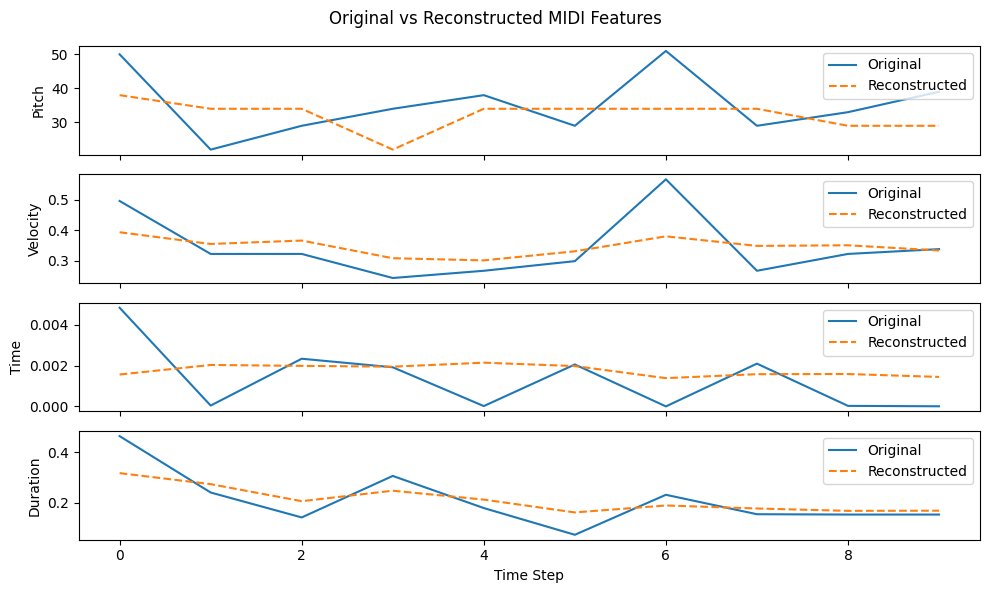

In [ ]:

model.eval()
with torch.no_grad():
    reconstructed = model(sample)
reconstructed_pitch = torch.argmax(reconstructed['pitch'], dim=-1)
reconstructed_velocity = reconstructed['velocity'].squeeze(-1)
reconstructed_time = reconstructed['time'].squeeze(-1)
reconstructed_duration = reconstructed['duration'].squeeze(-1)


reconstructed_seq = torch.stack([
    reconstructed_pitch,
    reconstructed_velocity,
    reconstructed_time,
    reconstructed_duration
], dim=-1).squeeze(0)

# for i in range(9):
#     orig = sample[0, i].cpu().numpy()
#     recon = reconstructed_seq[i].cpu().numpy()
    # print(f"{i:02d}: Orig: {orig}  |  Recon: {recon}")


fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
labels = ["Pitch", "Velocity", "Time", "Duration"]

for i in range(4):
    axs[i].plot(sample[0, :, i].cpu(), label="Original")
    axs[i].plot(reconstructed_seq[:, i].cpu(), label="Reconstructed", linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()

plt.xlabel("Time Step")
plt.suptitle("Original vs Reconstructed MIDI Features")
plt.tight_layout()
plt.show()


In [19]:
def iou_intervals(pred_start, pred_duration, target_start, target_duration):
    pred_end = pred_start + pred_duration
    target_end = target_start + target_duration
    
    inter_start = np.maximum(pred_start, target_start)
    inter_end = np.minimum(pred_end, target_end)
    intersection = np.maximum(0, inter_end - inter_start)

    union = np.maximum(pred_end, target_end) - np.minimum(pred_start, target_start)

    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.where(union > 0, intersection / union, 0.0)

    return iou


def unoffset_notes_start(notes: np.ndarray | torch.Tensor) -> np.ndarray:
    """Unoffsets start time"""
    if isinstance(notes, torch.Tensor):
        notes = notes.detach().cpu().numpy()
    if notes.shape[1] < 4:
        raise ValueError("Notes must have at least 4 columns (pitch, start, duration, velocity)")
    
    unoffset_start = np.cumsum(notes[:, 2])
    unoffset_notes = np.copy(notes)
    unoffset_notes[:, 2] = unoffset_start
    return unoffset_notes

def pitch_match_accuracy_iou_ordered(pred_notes: np.ndarray | torch.Tensor, target_notes: np.ndarray|torch.Tensor, iou_threshold=0.1):
    """
        Computes the pitch match accuracy and IoU for ordered notes. 
        Args:
            pred_notes (np.ndarray or torch.Tensor): Predicted notes of shape (N, 4) where each row is [pitch, velocity, start, duration].
            target_notes (np.ndarray or torch.Tensor): Target notes of shape (M, 4) with the same format.
            iou_threshold (float): IoU threshold for matching.
    """
    if isinstance(pred_notes, torch.Tensor):
        pred_notes = pred_notes.detach().cpu().numpy()
    if isinstance(target_notes, torch.Tensor):
        target_notes = target_notes.detach().cpu().numpy()
    N_pred = pred_notes.shape[0]
    N_target = target_notes.shape[0]
    pred_notes = unoffset_notes_start(pred_notes)
    target_notes = unoffset_notes_start(target_notes)
    # Compare up to the min length (to avoid indexing errors)
    N = min(N_pred, N_target)
    
    pred_pitch = pred_notes[:N, 0]
    pred_start = pred_notes[:N, 2]
    pred_duration = pred_notes[:N, 3]
    
    target_pitch = target_notes[:N, 0]
    target_start = target_notes[:N, 2]
    target_duration = target_notes[:N, 3]

    pitch_matches = (pred_pitch == target_pitch)
    ious = iou_intervals(pred_start, pred_duration, target_start, target_duration)

    # Match if pitch matches and IoU above threshold
    # TODO: change matches to mAP (logits are required so another function maybee )
    matches = pitch_matches & (ious >= iou_threshold)
    
    accuracy = pitch_matches.sum() / N if N > 0 else 0.0
    return accuracy, ious, matches


In [20]:


def plot_piano_roll_from_note_events(note_array: torch.Tensor|np.ndarray, figsize=(10, 4), title=None, fig=None, ax=None, show=True, show_colorbar=True, cmap='viridis'):
    """
    Expects a note array of shape (N, 4) where each row is [pitch, velocity, delta_time, duration].
    Args:
        note_array (torch.Tensor or np.ndarray): Array of note events.
        figsize (tuple): Size of the figure.
        title (str): Title of the plot.
        fig (plt.Figure): Figure to plot on, if None a new figure is created.
        ax (plt.Axes): Axes to plot on, if None a new axes is created.
        show (bool): Whether to show the plot.
        show_colorbar (bool): Whether to show the colorbar for velocities.
        cmap (str): Colormap to use for velocities.
    Returns:
        fig (plt.Figure): The figure object.
        ax (plt.Axes): The axes object.
    """
    if not isinstance(note_array, np.ndarray):
        note_array = note_array.detach().cpu().numpy()
    
    if note_array.ndim == 3:
        assert note_array.shape[0] == 1, "Expected note_array to be of shape (N, 4) or (1, N, 4)."
        note_array = note_array[0]
    

    scaled_pitches = np.clip(note_array[:, 0], 0, 127).astype(np.int8)
    velocities = np.clip(note_array[:, 1] * 127, 0, 127).astype(np.int8)
    note_delta = note_array[:, 2] * 255
    note_start = np.cumsum(note_delta)
    note_duration = note_array[:, 3] * 7
    note_end = note_start + note_duration

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    norm = mcolors.Normalize(vmin=0, vmax=127)
    if cmap != 'viridis':
        cmap = cm.get_cmap(cmap)
    else:
        cmap = cm.viridis
    vel_color = cmap(norm(velocities))

    for i in range(len(note_start)):
        ax.hlines(scaled_pitches[i], note_start[i], note_end[i],
                  colors=vel_color[i], linewidth=10, alpha=0.5)
    if show_colorbar:
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(velocities)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Velocity')
    
    ax.set_xlim(0, np.max(note_end) + 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pitch')
    ax.set_title('Piano Roll' if title is None else title)
    fig.tight_layout()
    if show:
        plt.show()
    return fig, ax


def compare_reco_true(true: torch.Tensor|np.ndarray, reco: torch.Tensor|np.ndarray, figsize=(10, 4), threshold=0.5, show=True):
    """
        Compares true and reconstructed piano rolls.
    """
    fig, ax = plt.subplots(figsize=figsize, sharex=True)
    plot_piano_roll_from_note_events(true, figsize=figsize, fig=fig, ax=ax, cmap='Blues', show=False)
    plot_piano_roll_from_note_events(reco, figsize=figsize, fig=fig, ax=ax, cmap='Reds', show=False)

    acc, iou, _ = pitch_match_accuracy_iou_ordered(
        reco, true, iou_threshold=threshold
    )
    ax.set_title('Comparison of True and Reconstructed Piano Rolls (Accuracy: {:.2f}, $\\overline{{IoU}} = {:.2f}$)'.format(acc, iou.mean()))
    legend_elements = [
        Patch(facecolor='blue', label='True'),
        Patch(facecolor='red', label='Reconstructed'),
    ]
    plt.legend(handles=legend_elements)
    if show:
        plt.show()
    return fig, ax

C:\Users\PC\AppData\Local\Temp\ipykernel_4048\2980035618.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap)


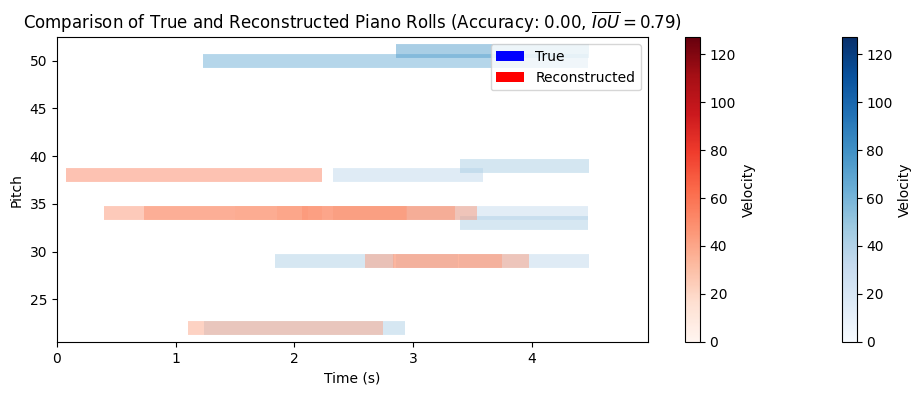

In [21]:
compare_reco_true(sample.squeeze(0), reconstructed_seq)
None

In [22]:
generated = model.sample(seq_len=128, device='cuda')

100%|██████████| 128/128 [00:00<00:00, 364.59it/s]


In [36]:
generated_seq = torch.stack([
    torch.tensor(generated['pitch'], dtype=torch.int32),
    torch.tensor(generated['velocity'], dtype=torch.float32),
    torch.tensor(generated['time'], dtype=torch.float32),
    torch.tensor(generated['duration'], dtype=torch.float32),
], dim=-1)

threshold = 0.2 # Set your velocity threshold
generated_seq = generated_seq[generated_seq[:, 1] >= threshold]

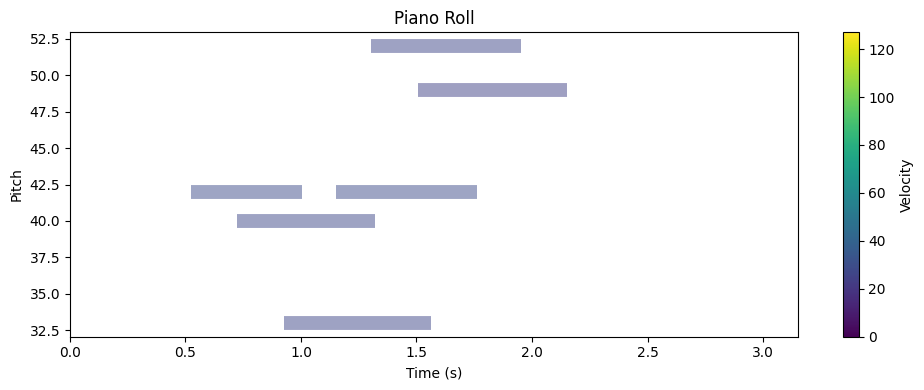

In [37]:
plot_piano_roll_from_note_events(generated_seq, show=True)
None

100%|██████████| 573/573 [00:15<00:00, 36.08it/s] 


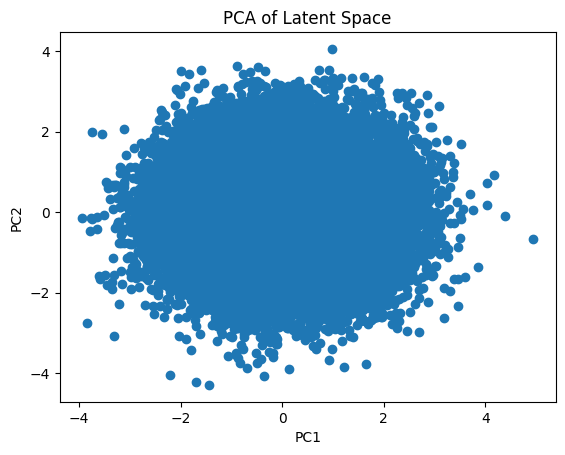

In [25]:

@torch.inference_mode
def plot_pca(samples: list[tuple[torch.Tensor, torch.Tensor]]):
    all_latents = []
    for mu, logvar in samples:
        reparam = mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
        all_latents.append(reparam.cpu().numpy())

    all_latents = np.concatenate(all_latents, axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_latents)

    plt.scatter(reduced[:, 0], reduced[:, 1])
    plt.title("PCA of Latent Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

model.eval()
eg_samples = []
with torch.no_grad():
    for t in tqdm(val_dl, desc=f""):
        t = t.cuda()
        r = model(t)
        eg_samples.append((r['mu'], r['logvar']))

plot_pca(eg_samples)

In [26]:
def tensor_to_piano_roll(note_tensor, fs: int = 64, pitch_range=(24, 84)) -> torch.Tensor:
    """
    Converts a [N, 4] note tensor (pitch, velocity, delta_start, duration) to a [T, P] piano roll.
    
    :param note_tensor: torch.Tensor or np.ndarray with shape [N, 4]
    :param fs: Frames per second (sampling rate of piano roll)
    :param pitch_range: Tuple indicating the pitch range (inclusive)
    :return: torch.Tensor of shape [T, P] with values in range [0, 1]
    """
    if isinstance(note_tensor, torch.Tensor):
        note_tensor = note_tensor.detach().cpu().numpy()

    if note_tensor is None or len(note_tensor) == 0:
        return torch.zeros((1, pitch_range[1] - pitch_range[0]))

    pitches = note_tensor[:, 0].astype(int)
    velocities = note_tensor[:, 1]
    delta_starts = note_tensor[:, 2] * 255.0
    durations = note_tensor[:, 3] * 7.0

    start_times = np.cumsum(delta_starts)
    end_times = start_times + durations

    max_time = int(np.ceil(end_times.max() * fs)) + 1
    num_pitches = pitch_range[1] - pitch_range[0]
    piano_roll = np.zeros((max_time, num_pitches), dtype=np.float32)

    for i in range(len(note_tensor)):
        pitch = int(pitches[i])
        velocity = velocities[i]
        start_idx = int(np.round(start_times[i] * fs))
        end_idx = int(np.round(end_times[i] * fs))
        pitch_idx = pitch - pitch_range[0]
        if 0 <= pitch_idx < num_pitches:
            piano_roll[start_idx:end_idx, pitch_idx] = velocity

    return torch.tensor(piano_roll, dtype=torch.float32)


In [27]:
gen_piano_roll = tensor_to_piano_roll(generated_seq, pitch_range=(2,62))
piano_roll_to_pretty_midi(gen_piano_roll, fs=64, path="genereted.mid")